https://www.googleapis.com/compute/v1/projects/first-220321/zones/us-east1-b/instances/abacus2
https://www.googleapis.com/compute/v1/projects/first-220321/zones/us-east1-b/instances/abacus3


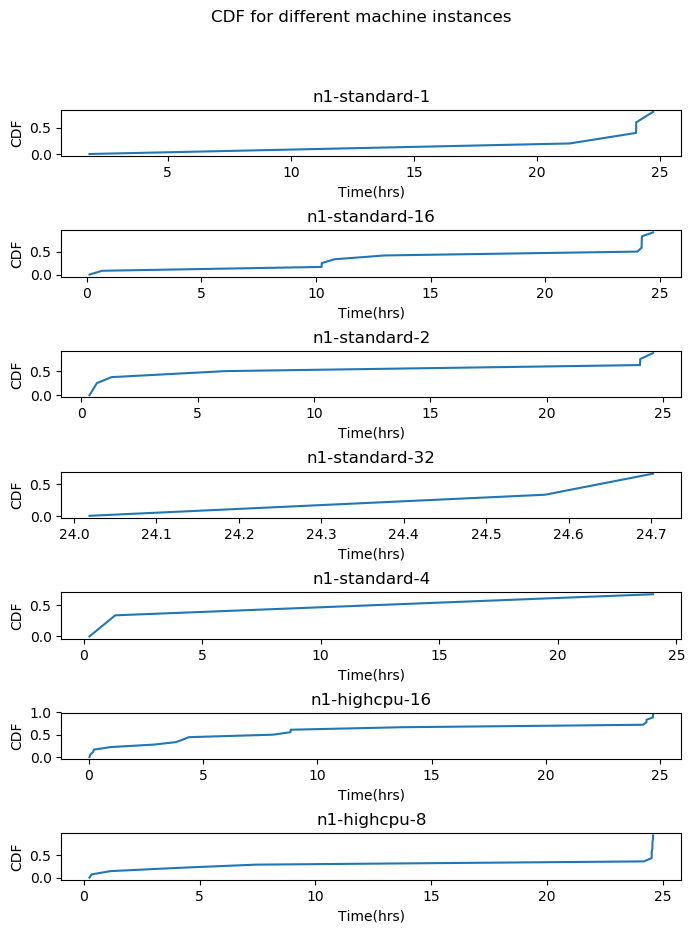

In [115]:
#Filtering data based on machine type
import json
import pandas as pd
import numpy as np
import time
import datetime
import dateutil.parser 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
import math
from scipy.integrate import quad
from scipy.optimize import curve_fit
import glob

#Instance types as a dic
instance_info = pd.read_csv('instances-m12.txt',delim_whitespace=True, header=None)
instances = pd.Series(instance_info[2].values,index=instance_info[0].values).to_dict()
del instances['NAME']

def ttl_in_minutes(start_time, end_time):
    s=dateutil.parser.parse(start_time)
    e=dateutil.parser.parse(end_time)
    diff = e-s
    return diff.total_seconds()

out = dict()
for file in sorted(glob.iglob('*.json')):
    with open(file) as json_file:  
        data = json.load(json_file)

    for entry in data:
        eid = entry['id']
        iname = entry['targetLink']
        if not iname in out:
            if entry['operationType']=='insert':
                out[iname] = (entry, np.nan)

    #Adding time data
    for entry in data:
        eid = entry['id']
        iname = entry['targetLink']      
        if entry['operationType']=='compute.instances.preempted':
            if iname in out:
                orig_entry = out[iname][0]
                start_time = orig_entry['insertTime']
                end_time = entry['insertTime']
                ttl = ttl_in_minutes(start_time, end_time)
                out[iname] = (orig_entry, ttl)
            
#removing the datapoint which did not have endtime
#removing the datapoint which have longer time than 30 hours
for i in list(out):
    if np.isnan(out[i][1]):
        out.pop(i)
    elif (out[i][1]/3600.0 > 30):
        print(out[i][0]['targetLink'])
        out.pop(i)
              
#Creating lists for eah machine type
all_data = dict()  
for key, value in out.items():   
    iname = key.split('/')[-1]
    if iname in instances:
        if instances[iname] in all_data:
            all_data[instances[iname]].append(value[1]/3600.0)
        else:
            all_data[instances[iname]] = [value[1]/3600.0]

#Sorting            
for key, value in all_data.items():
    all_data[key] = np.sort(all_data[key])
    
#plotting 
figure = plt.figure()
figure.set_size_inches(8, 10)
figure.subplots_adjust(hspace=1.6, wspace=1.0)
plt.suptitle('CDF for different machine instances') 
#ax = figure.add_subplot(111)
plot_count=1
grid_size=str(len(all_data))+'1'
for key, value in all_data.items():
    y = np.linspace(0,1,len(all_data[key]), endpoint=False)
    axi = figure.add_subplot(grid_size+str(plot_count))
    #ax=plt.subplot(grid_size+str(plot_count))
    #plt.subplot(222)
    plt.plot(all_data[key], y)
    plt.title(key)
    plt.xlabel("Time(hrs)")
    plt.ylabel("CDF")
    plot_count+=1
    #save the file
    data = np.column_stack((all_data[key],y))
    np.savetxt('E-CDF-'+key+'.txt',data,delimiter='\t')
plt.show() 

In [118]:
all_data

{'n1-highcpu-16': array([ 0.0260625 ,  0.06134028,  0.18160167,  0.22848222,  0.95020194,
         2.8316275 ,  3.80477361,  4.10479417,  4.37640194,  8.063095  ,
         8.82711667,  8.83354361, 13.6397875 , 24.24876556, 24.40241444,
        24.40457083, 24.6886675 , 24.69390833]),
 'n1-highcpu-8': array([ 0.23723083,  0.33425667,  1.15291306,  4.04760778,  7.43600111,
        24.18591611, 24.52930694, 24.53258917, 24.53300278, 24.56228944,
        24.56340333, 24.56616417, 24.59012056, 24.59217333]),
 'n1-standard-1': array([ 1.82317889, 21.32407972, 24.01686111, 24.02448528, 24.70971972]),
 'n1-standard-16': array([ 0.11144944,  0.65652278, 10.24200389, 10.24634806, 10.80266306,
        12.99917944, 24.02222611, 24.20612111, 24.20999528, 24.21473861,
        24.22076194, 24.70821028]),
 'n1-standard-2': array([ 0.34604472,  0.50689056,  0.664455  ,  1.29130583,  6.19542833,
        24.01101361, 24.02060806, 24.57288722]),
 'n1-standard-32': array([24.01877889, 24.57137167, 24.70246

# Example for curve fitting usig scipy

Text(0,0.5,'CDF')

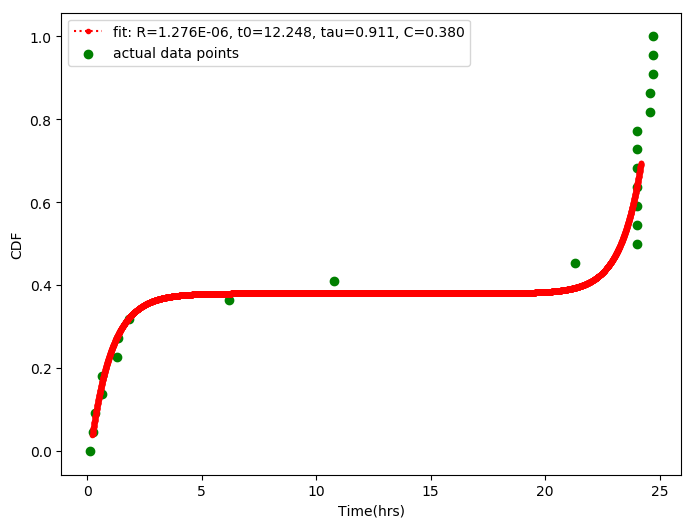

In [76]:
#curve fitting
def func_approximation(t, R, t0, tau, C):
    return R*np.sinh((t-t0)/tau) + C

xdata = np.array([86460.7, 2363.482, 86439.649, 88456.938, 895.826, 38889.587, 88462.394, 86474.189, 4648.701, 86488.147, 22303.542, 2392.038, 86480.014, 4810.814, 88928.863, 401.218, 1245.761, 88949.557, 88954.991, 86467.604, 76766.687, 6563.444, 86462.225])
xdata = np.sort(xdata)/3600
ydata = np.linspace(0,1,len(xdata))
plt.figure(figsize=(8, 6))
#plot data points
plt.scatter(xdata, ydata, c='green', label='actual data points')

#time data
time=np.linspace(data[0,0], data[-1,0], 10000)

optimized_params, param_covariance = curve_fit(func_approximation, xdata, ydata)

plt.plot(time, func_approximation(time, *optimized_params), c= "red", marker='.', linestyle=':', label='fit: R=%.3E, t0=%.3f, tau=%.3f, C=%.3f' % tuple(optimized_params))

plt.legend()
plt.xlabel("Time(hrs)")
plt.ylabel("CDF")

# Curve fitting for different machine types usig scipy

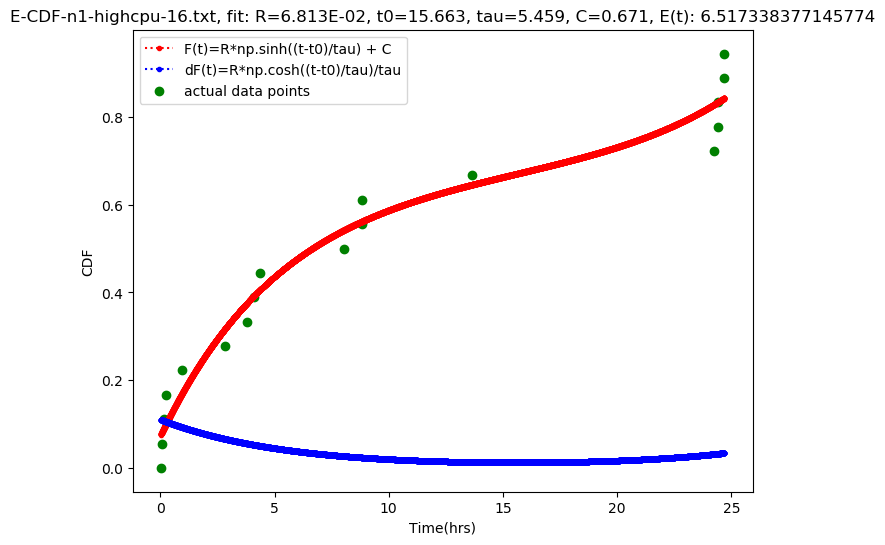

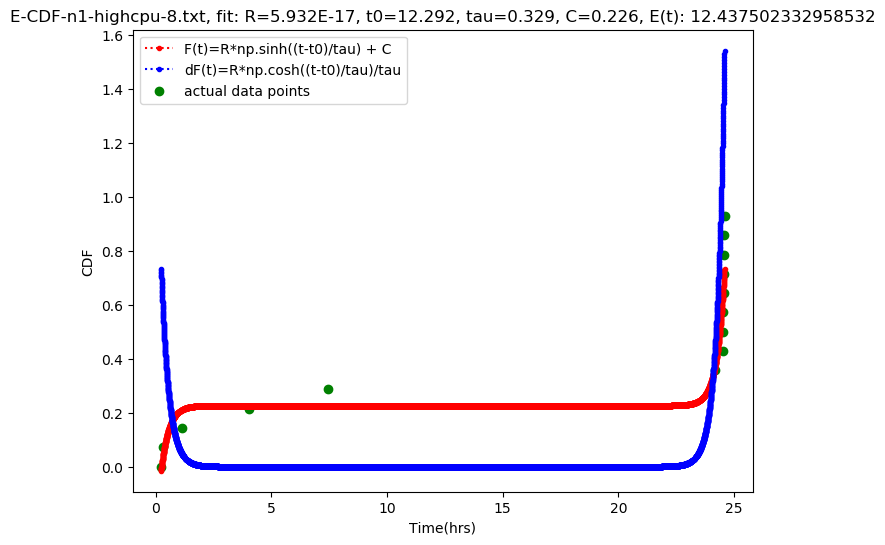

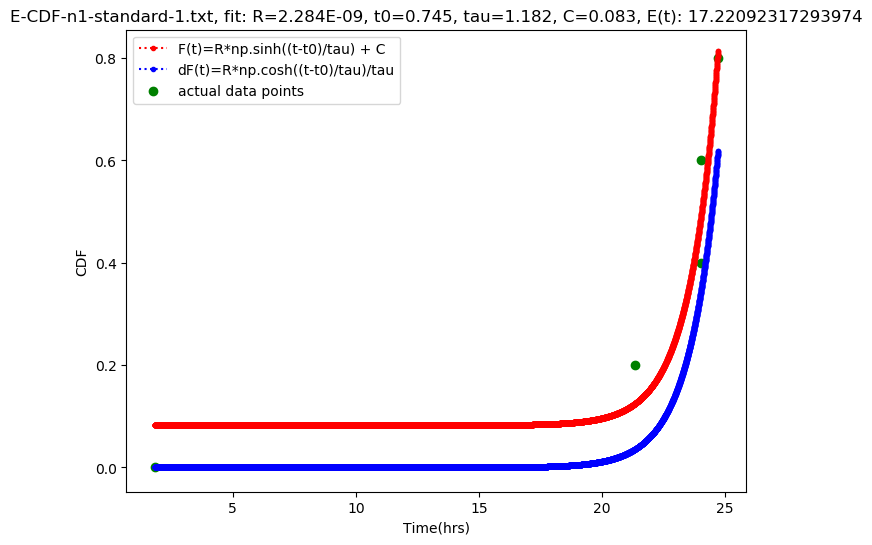

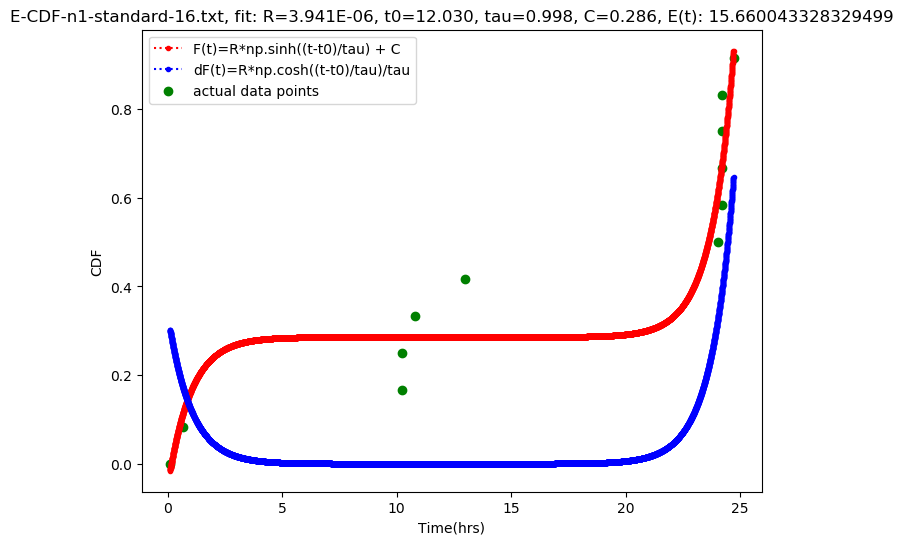

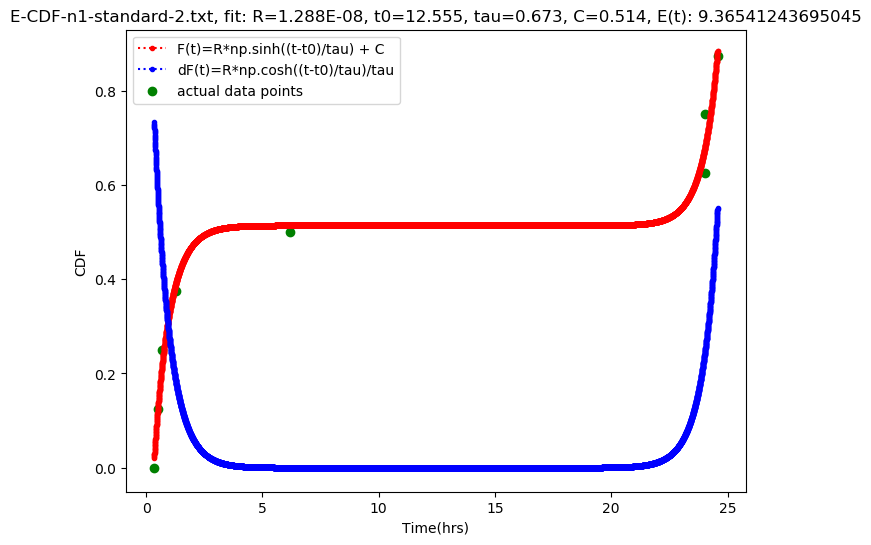

In [216]:
#curve fitting
def func_approx(t, R, t0, tau, C):
    return R*np.sinh((t-t0)/tau) + C

#derivative of the function
def func_approx_dif(t, R, t0, tau, C):
    return R*np.cosh((t-t0)/tau)/tau

#Exp
dPT = lambda t, R, t0, tau, C: t*R*np.cosh((t-t0)/tau)/tau

def fit_all_types():
    all_optimized_names = []
    all_optimized_params = []
    all_optimized_exp = []
    for file in sorted(glob.iglob('E-CDF-*.txt')):
        #load data
        data = np.loadtxt(file, delimiter='\t')
        if data.shape[0] > 3:
            plt.figure(figsize=(8, 6))
            #plot data points
            plt.scatter(data[:,0], data[:,1], c='green', label='actual data points')
            #fit the curve: method= 'trf', 'dogbox' or 'lm'
            #‘trf’ : Trust Region Reflective algorithm, particularly suitable for large sparse problems with bounds. Generally robust method.
            #‘dogbox’ : dogleg algorithm with rectangular trust regions, typical use case is small problems with bounds. Not recommended for problems with rank-deficient Jacobian.
            #‘lm’ : Levenberg-Marquardt algorithm as implemented in MINPACK. Doesn’t handle bounds and sparse Jacobians. Usually the most efficient method for small unconstrained problems.
            optimized_params, param_covariance = curve_fit(func_approx, data[:,0], data[:,1], maxfev=10000, method='dogbox')
            #time data
            t=np.linspace(data[0,0], data[-1,0], 10000)
            #Plot the fitted function
            plt.plot(t, func_approx(t, *optimized_params), c= "red", marker='.', linestyle=':', label='F(t)=R*np.sinh((t-t0)/tau) + C')
            #differentiation of the funtion
            plt.plot(t, func_approx_dif(t, *optimized_params), c= "blue", marker='.', linestyle=':', label='dF(t)=R*np.cosh((t-t0)/tau)/tau')
            x = plt.legend()
            plt.xlabel("Time(hrs)")
            plt.ylabel("CDF")
            
            #Expected value computation
            I = quad(func=dPT, a=data[0,0], b=data[-1,0],args=tuple(optimized_params))
            all_optimized_exp.append(I[0])
            
            #Plot text
            txt = ', fit: R=%.3E, t0=%.3f, tau=%.3f, C=%.3f' % tuple(optimized_params)
            
            text = file+txt+ ', E(t): '+str(I[0])
            plt.title(text)
            #plt.text(0,1.1,txt)
            all_optimized_params.append(optimized_params)
            all_optimized_names.append(text)
            
    return (all_optimized_names, all_optimized_params, all_optimized_exp)

all_optimized_names, all_optimized_params, exp = fit_all_types()

In [113]:
#Analytical solution
#intergration to find the expected value
#dPT = lambda t, R, t0, tau, C: t*R*np.cosh((t-t0)/tau)/tau
# When you integrate dPT by t: IdPT
IdPT = lambda t, R, t0, tau, C: R/tau* ( t*tau*np.sinh((t-t0)/tau) - (tau**2)*np.cosh((t-t0)/tau) )
t=data[-1,0]
ip_upper_bound = IdPT(t,*optimized_params)
t=data[0,0]
ip_lower_bound = IdPT(t,*optimized_params)
#accroding to mean value theorm
expected_value = (ip_upper_bound - ip_lower_bound)
expected_value

6.517337709555059

In [114]:
#Numerical Integration
dPT = lambda t, R, t0, tau, C: t*R*np.cosh((t-t0)/tau)/tau
I = quad(func=dPT, a=data[0,0], b=data[-1,0],args=tuple(optimized_params))
#accroding to mean value theorm
expected_value = I[0]
expected_value

6.517337709555059